In [21]:
import pandas as pd
import pdb
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 4,
    "device": 'cpu',
}

# Read the parquet file and get rough statistics

In [23]:
df = pd.read_parquet("enveda_chemist_annotations_hackathon.parquet.pq")
df.head()

,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts
7,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,0,1,0,0,0,0,0,0,1,1,None,None
8,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,1,1,0,0,0,0,0,0,1,1,None,None
9,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,2,1,0,0,0,0,0,0,1,1,None,None
10,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,3,0,1,0,0,0,0,1,0,1,c1cc2c(c3C=CCOc3cc2)[nH]1,[#6]1:[#6]:[#6]2:[#6](:[#6]3-[#6]=[#6]-[#6]-[#...
11,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,4,1,0,0,0,0,0,0,1,1,None,None


In [24]:
print(df.shape)

(1667, 18)


## Compute label distribution to understand class imbalance

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_1468/1918543378.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


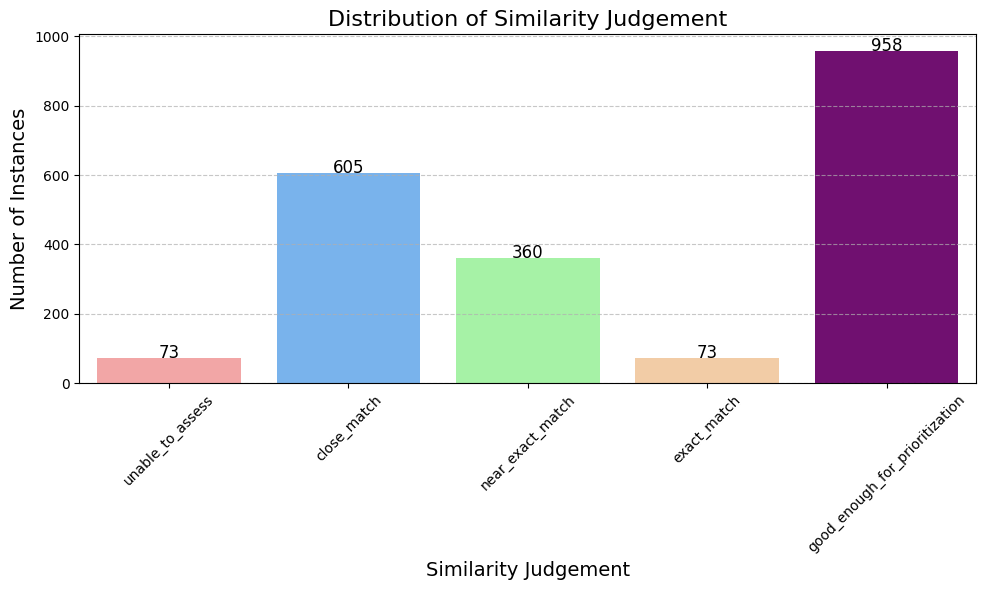

In [25]:
class_counts = df[['unable_to_assess','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum()

# Define colors for each class
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', 'purple'] # Customize colors as needed

# Create a bar plot to visualize class imbalance
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.title('Distribution of Similarity Judgement', fontsize=16)
plt.xlabel('Similarity Judgement', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of the bars
for index, value in enumerate(class_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
# Check for overlap in labels
labels = df[['unable_to_assess','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']]  # Select all rows and first five columns
# This will create a new DataFrame where each row is converted to a set of labels
overlap_check = labels.apply(lambda x: set(x), axis=1)

# Count how many rows have more than one label
multilabel_count = overlap_check.apply(lambda x: len(x) > 1).sum()

if multilabel_count > 0:
    print(f"There are {multilabel_count} instances with overlapping classes (multilabel classification).")
else:
    print("All instances have mutually exclusive classes (single-label classification).")

# Optional: Display the rows with overlapping classes for further inspection
if multilabel_count > 0:
    overlapping_rows = df[overlap_check.apply(lambda x: len(x) > 1)]
    print("Rows with overlapping classes:")
    print(overlapping_rows)

There are 1262 instances with overlapping classes (multilabel classification).
Rows with overlapping classes:
                                    ground_truth_smiles  \
7     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
8     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
9     CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
11    CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
12                           COc1ccc(OCCCS(=O)(=O)O)cc1   
...                                                 ...   
2329       CC=C1CN2C3CC1C1COC(c4c3[nH]c3cc(OC)ccc43)C12   
2330       CC=C1CN2C3CC1C1COC(c4c3[nH]c3cc(OC)ccc43)C12   
2332  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   
2333  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   
2335  CCC(C)c1[nH]c(O)c2n(c(O)c(Cc3ccccc3)[nH]c(O)c(...   

                                       predicted_smiles  \
7     CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...   
8     CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...   
9   

# Load Feature Extractor
This notebook uses MolFormer, but feel free to use any of the latest feature extractors, like SPMM, Grover, SelFormer, among others.

In [27]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


# Extract features per row

In [28]:
# Function to extract features
def extract_features(smiles):
    # Tokenize the SMILES string
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # pdb.set_trace()
    # Extract the last hidden state (embeddings)
    embeddings = outputs.pooler_output.cpu().numpy()
    return embeddings

    

In [ ]:
df['ground_truth_embeddings'] = df['ground_truth_smiles'].apply(extract_features)
df['predicted_embeddings'] = df['predicted_smiles'].apply(extract_features)


In [ ]:
df[['predicted_smiles', 'predicted_embeddings']].head()

In [ ]:
print(df['predicted_embeddings'].iloc[42].shape)
df['predicted_embeddings'].iloc[42]

# Save into pickle file for reuse and avoid recomputing features

In [ ]:
# Save the DataFrame to a pickle file
df.to_pickle('enveda_chemist_preprocessed.pkl')